In [29]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict, Any, List


class GraphAnalyzerCIDM:
    def __init__(self, graph_file: str) -> None:
        """
        Initialize the graph from a JSON file.

        Parameters
        ----------
        graph_file : str
            Path to the JSON file containing the graph data.
        """
        self.graph_file: str = graph_file
        self.G: nx.DiGraph = nx.DiGraph()
        self.load_graph()
        
    def load_graph(self) -> None:
        """Load graph data from JSON and create a NetworkX graph."""
        with open(self.graph_file, "r") as f:
            graph_data: Dict[str, Any] = json.load(f)
        
        # Add nodes with weights
        for node_id, node_data in graph_data.items():
            self.G.add_node(node_id, **node_data["weights"])
        
        # Add edges with operational reliance as weight
        for node_id, node_data in graph_data.items():
            for target_id, edge_weight in node_data["edges"].items():
                self.G.add_edge(node_id, target_id, weight=edge_weight)
    
    def visualize(
        self,
        min_size: int = 100,
        max_size: int = 2000,
        edge_scale: float = 10.0,
        layout: str = "spring",
        seed: int = 42
    ) -> None:
        """Visualize the graph with node sizes, colors, and edge widths."""
        globals_list: List[float] = [self.G.nodes[n]["global"] for n in self.G.nodes]
        min_val, max_val = min(globals_list), max(globals_list)
        node_sizes = [
            min_size + (val - min_val) / (max_val - min_val) * (max_size - min_size)
            for val in globals_list
        ]
        
        node_colors: List[float] = [self.G.nodes[n]["societal"] for n in self.G.nodes]
        edge_widths: List[float] = [self.G[u][v]["weight"] * edge_scale for u, v in self.G.edges]
        
        # Choose layout
        if layout == "spring":
            pos = nx.spring_layout(self.G, k=0.5, seed=seed)
        elif layout == "circular":
            pos = nx.circular_layout(self.G)
        elif layout == "kamada_kawai":
            pos = nx.kamada_kawai_layout(self.G)
        else:
            raise ValueError("Unsupported layout type")
        
        # Draw graph
        plt.figure(figsize=(12, 12))
        nx.draw_networkx_nodes(
            self.G, pos, node_size=node_sizes, node_color=node_colors,
            cmap=plt.cm.viridis, alpha=0.8
        )
        nx.draw_networkx_edges(
            self.G, pos, width=edge_widths, alpha=0.6,
            arrowstyle="-|>", arrowsize=15
        )
        nx.draw_networkx_labels(self.G, pos, font_size=8, font_color="black")
        plt.title(
            "Company Dependency Graph\n"
            "Node size = Global criticality, Edge width = Operational reliance"
        )
        plt.colorbar(
            plt.cm.ScalarMappable(cmap=plt.cm.viridis),
            label="Societal criticality"
        )
        plt.axis("off")
        plt.show()
    
    def centrality(self) -> Dict[str, float]:
        """Compute degree centrality."""
        return nx.degree_centrality(self.G)
    
    def shortest_path(self, source: str, target: str) -> List[str]:
        """Compute shortest path from source to target (weighted by edge weight)."""
        return nx.shortest_path(self.G, source=source, target=target, weight='weight')
    
    def summary(self) -> None:
        """Print a quick summary of the graph."""
        print(f"Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()}")
        print("Nodes with attributes:", list(self.G.nodes(data=True))[:5])
        print("Edges with attributes:", list(self.G.edges(data=True))[:5])

In [30]:
# Create analyzer instance
analyzer = GraphAnalyzerCIDM("../data/graph_data.json")

In [31]:
analyzer.summary()

Nodes: 30, Edges: 190
Nodes with attributes: [('COMP001', {'societal': 91.09, 'economic': 8627.86, 'global': 3932.64}), ('COMP002', {'societal': 87.81, 'economic': 16902.31, 'global': 7654.34}), ('COMP003', {'societal': 72.73, 'economic': 47460.27, 'global': 21397.12}), ('COMP004', {'societal': 34.27, 'economic': 16600.78, 'global': 7489.2}), ('COMP005', {'societal': 82.21, 'economic': 45902.79, 'global': 20701.47})]
Edges with attributes: [('COMP001', 'COMP021', {'weight': 0.224}), ('COMP001', 'COMP008', {'weight': 0.253}), ('COMP001', 'COMP024', {'weight': 0.327}), ('COMP001', 'COMP012', {'weight': 0.299}), ('COMP001', 'COMP023', {'weight': 0.24})]


In [32]:
print(analyzer.centrality())

{'COMP001': 0.3448275862068966, 'COMP002': 0.41379310344827586, 'COMP003': 0.3793103448275862, 'COMP004': 0.6551724137931034, 'COMP005': 0.6551724137931034, 'COMP006': 0.3448275862068966, 'COMP007': 0.3103448275862069, 'COMP008': 0.4482758620689655, 'COMP009': 0.6896551724137931, 'COMP010': 0.3793103448275862, 'COMP011': 0.3448275862068966, 'COMP012': 0.4482758620689655, 'COMP013': 0.3793103448275862, 'COMP014': 0.41379310344827586, 'COMP015': 0.5517241379310345, 'COMP016': 0.20689655172413793, 'COMP017': 0.3793103448275862, 'COMP018': 0.41379310344827586, 'COMP019': 0.41379310344827586, 'COMP020': 0.24137931034482757, 'COMP021': 0.3793103448275862, 'COMP022': 0.5862068965517241, 'COMP023': 0.41379310344827586, 'COMP024': 0.5517241379310345, 'COMP025': 0.3448275862068966, 'COMP026': 0.3448275862068966, 'COMP027': 0.3793103448275862, 'COMP028': 0.7586206896551724, 'COMP029': 0.41379310344827586, 'COMP030': 0.5172413793103449}


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

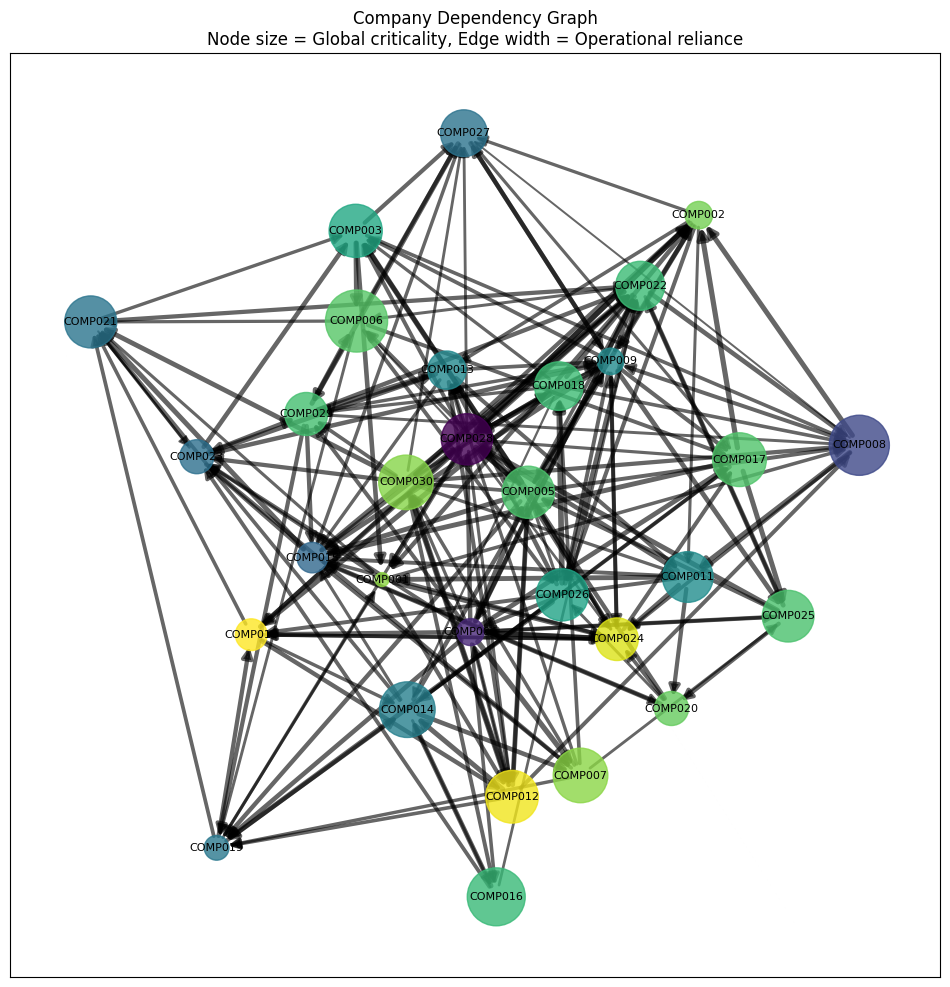

In [33]:
analyzer.visualize(layout="spring")

In [2]:
import json

In [3]:
# Load NAICS JSON from file
with open("../data/NAICS_codes.json", "r") as f:
    naics_data = json.load(f)

naics_codes = []

for element in naics_data:
    naics_codes.append(element["2022 NAICS US Code"])

In [6]:
list

['111',
 '112',
 '113',
 '114',
 '115',
 '211',
 '212',
 '213',
 '221',
 '236',
 '237',
 '238',
 '311',
 '312',
 '313',
 '314',
 '315',
 '316',
 '321',
 '322',
 '323',
 '324',
 '325',
 '326',
 '327',
 '331',
 '332',
 '333',
 '334',
 '335',
 '336',
 '337',
 '339',
 '423',
 '424',
 '425',
 '441',
 '444',
 '445',
 '449',
 '455',
 '456',
 '457',
 '458',
 '459',
 '481',
 '482',
 '483',
 '484',
 '485',
 '486',
 '487',
 '488',
 '491',
 '492',
 '493',
 '512',
 '513',
 '516',
 '517',
 '518',
 '519',
 '521',
 '522',
 '523',
 '524',
 '525',
 '531',
 '532',
 '533',
 '541',
 '551',
 '561',
 '562',
 '611',
 '621',
 '622',
 '623',
 '624',
 '711',
 '712',
 '713',
 '721',
 '722',
 '811',
 '812',
 '813',
 '814',
 '921',
 '922',
 '923',
 '924',
 '925',
 '926',
 '927',
 '928']